# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<hr>

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv. 


- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**

1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.
<hr>


**Этапы выполнения проекта:**
1. Загрузка и подготовка данные.
 1. Изучение таблиц на пропуски и несоотвестсвие типов данных
 2. Изучение описания и графиков на предмет аномальных значений
 3. Предобработка данных
 4. Исследовательский анализ
 5. Корреляционный анализ
2. Обучите и проверьте модель для каждого региона:
 1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 2. Обучите модель и сделайте предсказания на валидационной выборке.
 3. Сохраните предсказания и правильные ответы на валидационной выборке.
 4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
 5. Проанализируйте результаты.
3. Подготовьтесь к расчёту прибыли:
 1. Все ключевые значения для расчётов сохраните в отдельных переменных.
 2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
 3. Напишите выводы по этапу подготовки расчёта прибыли.
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 1. Выберите скважины с максимальными значениями предсказаний. 
 2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 3. Рассчитайте прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона:
 1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

### Установка компонентов

In [1]:
%%capture
!pip install phik
!pip install shap
!pip install mlxtend
!pip install -U scikit-learn

### Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import seaborn as sns
import phik
import shap

#для нахождения доверительного интервала
from scipy import stats as st

#библиотеки для работы с графиками
import matplotlib.pyplot as plt 
from mlxtend.plotting import plot_decision_regions
from itertools import combinations

#класс для разделения данных на выборки
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV, 
    GridSearchCV
)

#модели
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

#импорт класса дамми-модели 
from sklearn.dummy import DummyClassifier

#метод для отбора признаков модели
from sklearn.feature_selection import SelectKBest, f_classif

#метрики
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.metrics import(
    confusion_matrix, 
    accuracy_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    mean_squared_error
)

#классы подготовки данных
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler, 
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

#класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

### Указание констант

In [3]:
TEST_SIZE = 0.25
state = np.random.RandomState(12345)

## Загрузка и подготовка данных

In [4]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

data = [data_0, data_1, data_2]

for i in range(3):
    print(f'Data_{i}')
    display(data[i].head())
    print('_'*120, '\n')

Data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


________________________________________________________________________________________________________________________ 

Data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


________________________________________________________________________________________________________________________ 

Data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


________________________________________________________________________________________________________________________ 



### Изучение данных

In [5]:
for i in range(3):
    print(f'Data_{i} \n')
    data[i].info()
    display(data[i].describe().T)
    display(data[i].shape)
    print('_'*120, '\n')

Data_0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


(100000, 5)

________________________________________________________________________________________________________________________ 

Data_1 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


(100000, 5)

________________________________________________________________________________________________________________________ 

Data_2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


(100000, 5)

________________________________________________________________________________________________________________________ 



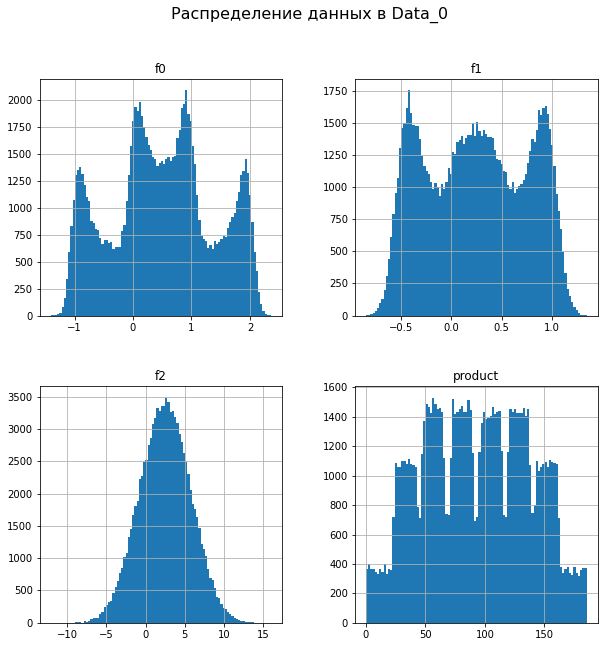

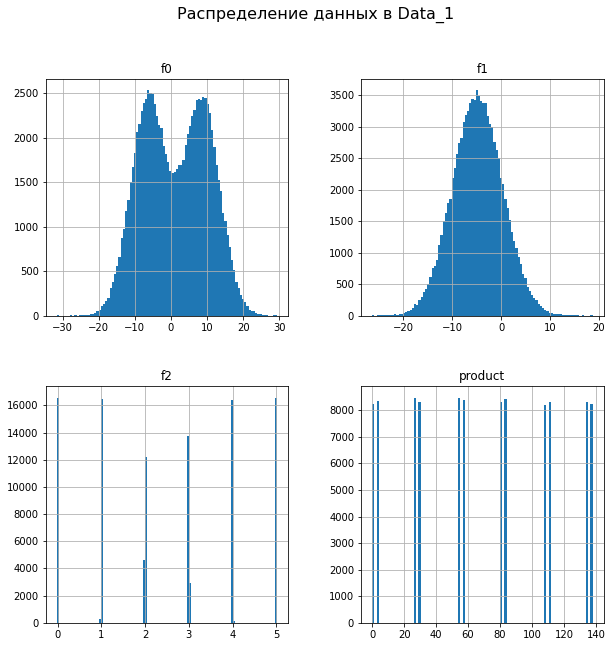

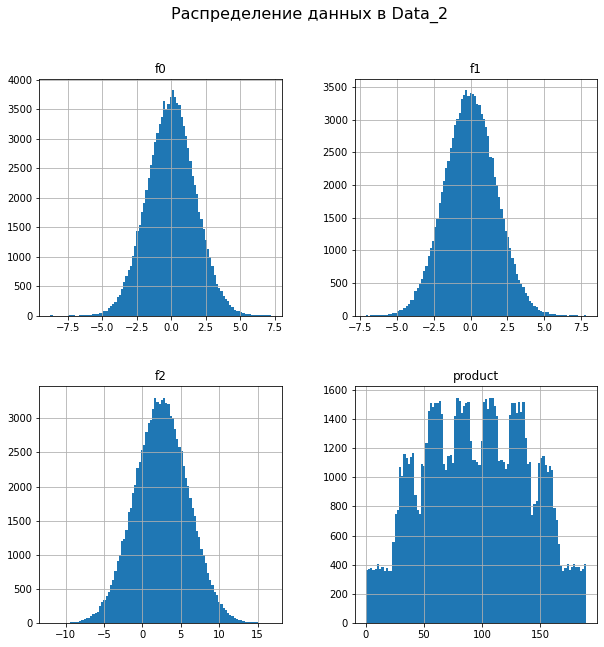

In [6]:
for i in range(3):
    data[i].hist(figsize = (10, 10), bins = 100)
    plt.suptitle(f'Распределение данных в Data_{i}', fontsize = 16);

### Поиск дубликатов

#### Неявные дубликаты

In [7]:
for i in range(3):
    id = data[i].loc[data[i]['id'].duplicated(), 'id'].values
    print(f'Неявные дубликаты в data{i}: {id} \n')
    for item in id:
        print(data[i].loc[data[i]['id'] == item], '\n')
    print('_'*120, '\n')

Неявные дубликаты в data0: ['HZww2' 'bxg6G' 'A5aEY' 'QcMuo' '74z30' 'AGS9W' 'Tdehs' 'fiKDv' 'TtcGQ'
 'bsk9y'] 

         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695 

          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798 

          id        f0        f1        f2    product
3389   A5aEY -0.039949  0.156872  0.209861  89.249364
51970  A5aEY -0.180335  0.935548 -2.094773  33.020205 

          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675 

          id        f0        f1        f2     product
64022  74z30  0.741456  0.459229  5.153109  140.771492
66136  74z30  1.084962 -0.312358  6.990771  127.643327 

          id        f0        f1        f2     product
42529  

Во всех трех датафреймах наблюдаются неявные дубликаты в столбце идентификатора. Можно предположить, что произошел сбой при внесении данных, но точной причины не указано. Решение: оставить дубликаты, т.к. среди данных строк нет полных дубликатов и все значения их атрибутов разные.

#### Явные дубликаты

In [8]:
for i in range(3):
    print(f'Дубликаты в Data_{i} \n')
    display(data[i].duplicated().sum())
    print('_'*120, '\n')

Дубликаты в Data_0 



0

________________________________________________________________________________________________________________________ 

Дубликаты в Data_1 



0

________________________________________________________________________________________________________________________ 

Дубликаты в Data_2 



0

________________________________________________________________________________________________________________________ 



### Исследовательский анализ

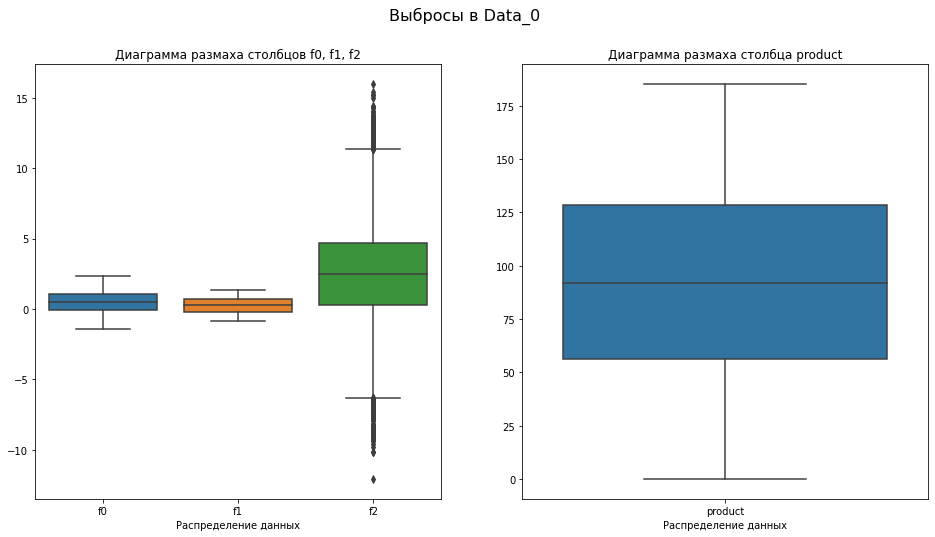

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


________________________________________________________________________________________________________________________


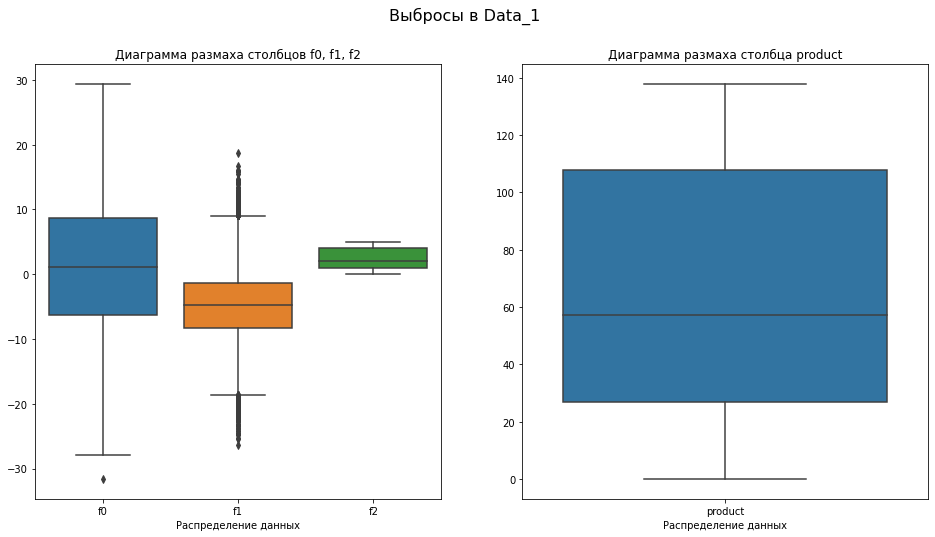

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


________________________________________________________________________________________________________________________


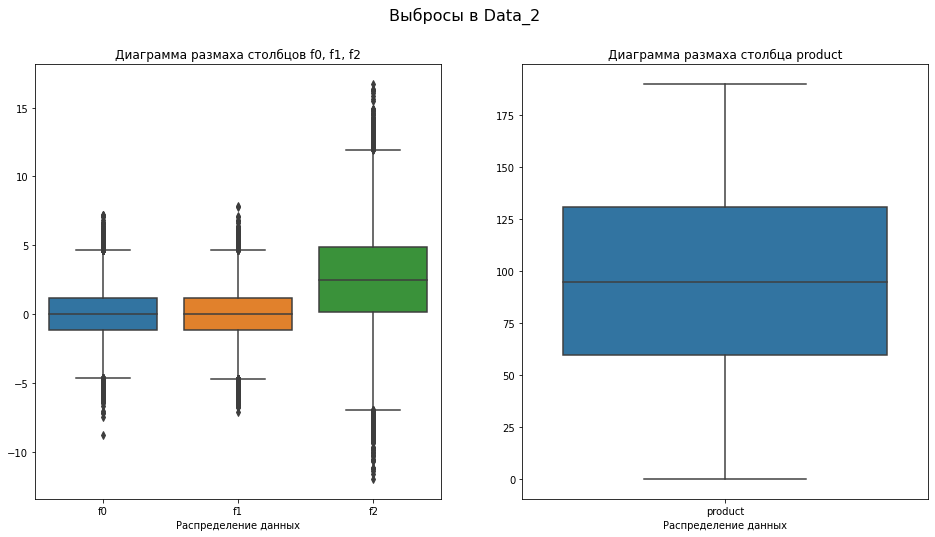

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


________________________________________________________________________________________________________________________


In [9]:
for i in range(3):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
    
    sns.boxplot(data = data[i][['f0', 'f1', 'f2']], ax=axs[0])
    axs[0].set_xlabel('Распределение данных')
    axs[0].set_title('Диаграмма размаха столбцов f0, f1, f2')
    
    sns.boxplot(data = data[i][['product']], ax=axs[1])
    axs[1].set_xlabel('Распределение данных')
    axs[1].set_title('Диаграмма размаха столбца product')
    fig.suptitle(f'Выбросы в Data_{i} \n', fontsize = 16)
      
    plt.show()
    
    display(data[i].describe())
    print('_'*120)
    

### Корреляционный анализ

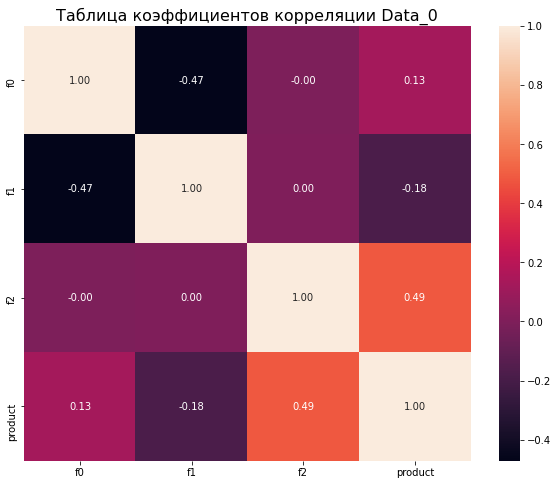

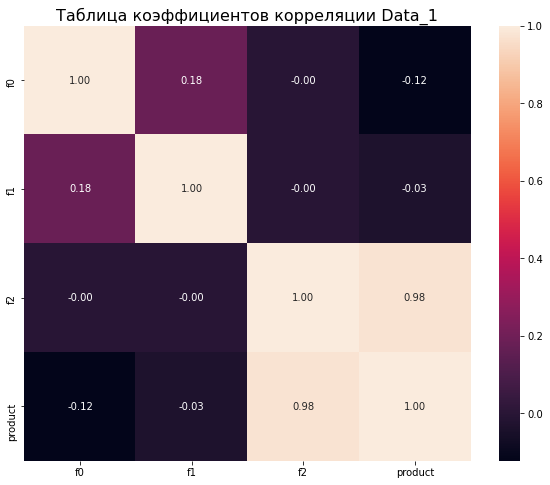

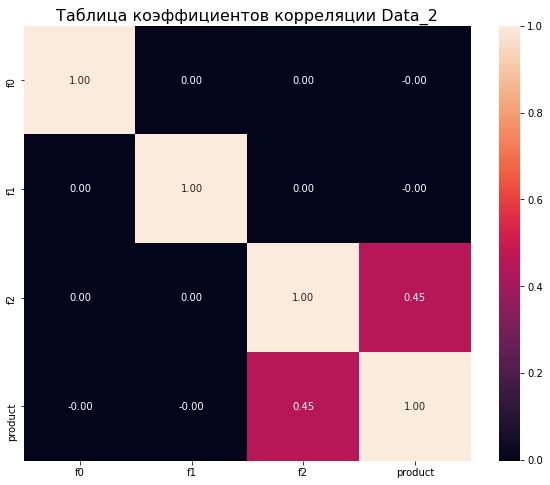

In [10]:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(data[i].corr(method = 'spearman'), annot = True, fmt = '.2f')
    plt.title(f'Таблица коэффициентов корреляции Data_{i}', fontsize = 16);
    

**Вывод**

Пропусков и дубликатов в данных не обнаружено, несоответствия типов данных не обнаружено, заголовки соотвестсвуют правилам snake_case.

Из графиков распределения данных видно, что в каждом регионе данные распределены по разному. Особое внимание стоит уделить таблице `data_1`, столбцам `f2` и `product`, т.к. данные в них распределены аномально, что может препятствовать качественному обучению модели. Из сравнения среднего значения и второго квартиля цифры не чильно отличаюся, кроме `product` в `data_1`, который имеет большой разброс значений при показателе стандартного отклонения в 45.9.

Из корреляционного анализа обнаружено сильное влияние признака `f2` на `product`.

## Обучение и проверка модели

**Целевой признак** - `product`

**Входные признаки** - `f0, f1, f2`

Идентификатор удалим, т.к. он не влияет на другие признаки и результаты модели.

Масштабирование будем проводить с помощью StandartScaler(). Для оценки работы модели будем использовать RMSE, т.к. в целевом признаке нет выбросов, что могло бы увеличить показатель ошибки. 

In [11]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
])

results = []

for i in range(3):
    features = data[i].drop(['id', 'product'], axis = 1)
    target = data[i]['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        features,
        target,
        test_size = TEST_SIZE,
        random_state = state
    )
    
    print(f'Размерность тренировочной выборки {i}: {X_train.shape} и {y_train.shape}')
    print(f'Размерность валидационной выборки {i}: {X_valid.shape} и {y_valid.shape} \n')
    
    pipe.fit(X_train, y_train)
    
    predict = pipe.predict(X_valid)
    
    print(f'Регион {i}:')
    print(f'Фактический показатель сырья: {y_valid.mean():.2f} т. баррелей')
    print(f'Предсказаный показатель сырья: {predict.mean():.2f} т.баррелей')
    print(f'Разница показателей: {y_valid.mean() - predict.mean():.2f}')
    print(f'RMSE модели: {mean_squared_error(y_valid, predict, squared = False):.2f}')
    print('_'*120, '\n')
    
    #сохраняем списки с результатами предсказаний
    exec(f'preds{i} = pd.Series(predict)')
    exec(f'y_valid_{i} = pd.Series(y_valid)')

Размерность тренировочной выборки 0: (75000, 3) и (75000,)
Размерность валидационной выборки 0: (25000, 3) и (25000,) 

Регион 0:
Фактический показатель сырья: 92.08 т. баррелей
Предсказаный показатель сырья: 92.59 т.баррелей
Разница показателей: -0.51
RMSE модели: 37.58
________________________________________________________________________________________________________________________ 

Размерность тренировочной выборки 1: (75000, 3) и (75000,)
Размерность валидационной выборки 1: (25000, 3) и (25000,) 

Регион 1:
Фактический показатель сырья: 68.77 т. баррелей
Предсказаный показатель сырья: 68.77 т.баррелей
Разница показателей: 0.00
RMSE модели: 0.89
________________________________________________________________________________________________________________________ 

Размерность тренировочной выборки 2: (75000, 3) и (75000,)
Размерность валидационной выборки 2: (25000, 3) и (25000,) 



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Регион 2:
Фактический показатель сырья: 94.75 т. баррелей
Предсказаный показатель сырья: 95.09 т.баррелей
Разница показателей: -0.34
RMSE модели: 39.96
________________________________________________________________________________________________________________________ 



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
predict = [preds0, preds1, preds2]

print(f'Результаты предсказания data_0 \n{preds0.head()}\n')
print(f'Результаты предсказания data_1 \n{preds1.head()}\n')
print(f'Результаты предсказания data_2 \n{preds2.head()}')

Результаты предсказания data_0 
0    95.894952
1    77.572583
2    77.892640
3    90.175134
4    70.510088
dtype: float64

Результаты предсказания data_1 
0     54.238152
1     83.217878
2      2.971467
3     25.916480
4    111.341137
dtype: float64

Результаты предсказания data_2 
0    112.561878
1     69.464073
2     69.866229
3    110.331048
4     95.123288
dtype: float64


Почти во всех моделях предсказаный показатель сырья не сильно отличается от фактического. Что касается RMSE, то наименьший показатель ошибки 0.88 у второго датасета, остальные имеют большие показатели(37.47, 40.10) отклонения предсказания от истинного значения - отражает большой разброс значений в целевом показателе. 

**Вывод** - предсказания не отражают реальный запас сырья с высокой точностью.

## Подготовка к расчёту прибыли

Условия:

1. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [13]:
#Общее количество исследуемых точек
POINTS = 500
BEST_POINTS = 200

#Бюджет на разработку скважин
BUDGET = 10e9

#Доход с единицы продукта
PRICE = 450e3

LIMIT = 0.025

In [14]:
#Достаточный объем сырья для каждого региона
volume_reg = BUDGET/PRICE
print(f'Достаточный объём сырья для каждого региорна: {volume_reg:.2f} т. баррелей')

#Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.
volume = BUDGET/(PRICE * BEST_POINTS)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {volume:.2f} т. баррелей')    

Достаточный объём сырья для каждого региорна: 22222.22 т. баррелей
Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 т. баррелей


In [15]:
for i in range(3):  
    print(f'Регион {i}')
    print(f'Средний запас сырья в регионе: {data[i]["product"].mean():.2f} т. баррелей')
    print(f'Средний предсказанный запас региона: {predict[i].mean():.2f} т.баррелей')
    print(f'Количество скважин с запасом больше, чем порог: {len(data[i].query("product > @volume"))}')
    print(f'Процент скважин с запасом больше, чем порог: {len(data[i].query("product > @volume"))/len(data[i]):.2%}')
    print('_'*120, '\n')

Регион 0
Средний запас сырья в регионе: 92.50 т. баррелей
Средний предсказанный запас региона: 92.59 т.баррелей
Количество скважин с запасом больше, чем порог: 36583
Процент скважин с запасом больше, чем порог: 36.58%
________________________________________________________________________________________________________________________ 

Регион 1
Средний запас сырья в регионе: 68.83 т. баррелей
Средний предсказанный запас региона: 68.77 т.баррелей
Количество скважин с запасом больше, чем порог: 16537
Процент скважин с запасом больше, чем порог: 16.54%
________________________________________________________________________________________________________________________ 

Регион 2
Средний запас сырья в регионе: 95.00 т. баррелей
Средний предсказанный запас региона: 95.09 т.баррелей
Количество скважин с запасом больше, чем порог: 38178
Процент скважин с запасом больше, чем порог: 38.18%
____________________________________________________________________________________________________

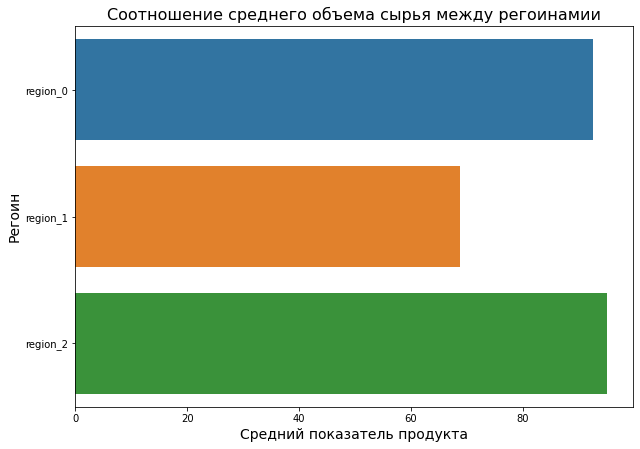

In [16]:
df = pd.DataFrame(
    {
        '1': ['region_0', 92.50],
        '2': ['region_1', 68.83],
        '3': ['region_2', 95.00],
    })
df = df.T
df.columns = ['region', 'mean_product_volume']

fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(data = df,
           x = 'mean_product_volume',
           y = 'region')

plt.title('Соотношение среднего объема сырья между регоинамии', fontsize = 16)
plt.xlabel('Средний показатель продукта', fontsize = 14)
plt.ylabel('Регоин', fontsize = 14);

Все необходимые показатели были определены в отдельные переменные. После подсчета достаточного количества сырья была получена следующая цифра - 111.11 т. баррелей. Именно столько необходимо получать с 200 лучших точек региона для безубыточной разработки новой скважины. Процент скважин в регионе, с которых получают больше, чем с данного порога:
- Регион 0
  - Количество скважин с запасом больше, чем порог: 36583
  - Процент скважин с запасом больше, чем порог: 36.58%
- Регион 1
  - Количество скважин с запасом больше, чем порог: 16537
  - Процент скважин с запасом больше, чем порог: 16.54%
- Регион 2
  - Количество скважин с запасом больше, чем порог: 38178
  - Процент скважин с запасом больше, чем порог: 38.18%

## Расчёт прибыли и рисков 

Функция для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [17]:
def revenue(target, predict, count):
    # РЕВЬЮЕР: здесь могли бы быть твои сбросы индексов!
    target = target.reset_index(drop = True)
    predict = predict.reset_index(drop = True)
    
    preds_sorted = predict.sort_values(ascending = False)[:count]
    selected = target[preds_sorted.index]
    
    # КОД РЕВЬЮЕРА, DEBUG
    if target[preds_sorted.index].shape[0] != preds_sorted.shape[0]:
        print(f"Shape mismatch! You took {target[preds_sorted.index].shape[0]} target values!")


    summa = selected.sum()
    revenue = summa * PRICE
    return revenue - BUDGET

In [18]:
y_valid = [y_valid_0, y_valid_1, y_valid_2]

for i in range(3):
    y_valid[i] = y_valid[i].reset_index(drop = True)
    
    values = []
    
    for _ in range(1000):
        target_samples = y_valid[i].sample(POINTS, random_state = state, replace = True)
        preds_samples = predict[i][target_samples.index]
        values.append(revenue(target_samples, preds_samples, BEST_POINTS))
    
    values = pd.Series(values) 
        
    #Средняя прибыль
    mean = values.mean() / 10e6
        
    #Верхний и нижний квартили доверительного интервала. 2.5% и 97.5% от 95% 
    lower = values.quantile(.025) /10e6
    upper = values.quantile(.975) /10e6
        
    risk = (values.apply(lambda x: x < 0).sum()).mean() / len(values)
    
    print(f'Регион {i}')
    print(f'Средняя прибыль: {mean:.0f} млн. рублей')
    print(f'Доверительный интервал: от {lower:.0f} до {upper:.0f} млн. рублей')
    print(f'Риск убытков: {risk:.2%}')
    print('_'*120, '\n')    

Регион 0
Средняя прибыль: 39 млн. рублей
Доверительный интервал: от -7 до 92 млн. рублей
Риск убытков: 6.10%
________________________________________________________________________________________________________________________ 

Регион 1
Средняя прибыль: 45 млн. рублей
Доверительный интервал: от 6 до 86 млн. рублей
Риск убытков: 0.70%
________________________________________________________________________________________________________________________ 

Регион 2
Средняя прибыль: 35 млн. рублей
Доверительный интервал: от -16 до 85 млн. рублей
Риск убытков: 7.60%
________________________________________________________________________________________________________________________ 



**Вывод** 

Исходя из рассчетов рисков и прибыли самая большая сумма прибыли наблюдается во **втором** регионе с наименьшим риском убытков среди всех представленных:
 - Средняя прибыль: 45 млн. рублей
 - Доверительный интервал: от 6 до 86 млн. рублей
 - Риск убытков: 0.70%

**Для разработки скважин можно порекомендовать данный регион.**

Для сравнения можно привести третий регион с самой малой прибылью и наибольшим процентом риска убытков

- Средняя прибыль: 35 млн. рублей
- Доверительный интервал: от -16 до 85 млн. рублей
- Риск убытков: 7.60%

# Вывод

1. В ходе проекта был проведен исследовательский анализ данных, чтобы выявить аномалии, дубликаты и выбросы в данных. Также построены матрицы корреляции для наглядного представления влияния признаков друг на друга. 
2. Обучена модель логистической регрессии для подсчета средней прибыли в каждом регионе. Качество работы модели было проверено с помощью метрики RMSE
3. Проведен подсчет прибыли и рисков для выявления наилучшего региона для разработки скважин: Второй регион сос редней прибылью в 45 млн.рублей и процентом риска 0.70%